In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageEnhance
from pathlib import Path
import matplotlib.pyplot as plt

def get_device_choice():
    """Ask user for their device preference"""
    while True:
        choice = input("Choose device (cuda/cpu): ").lower().strip()
        if choice in ['cuda', 'cpu']:
            if choice == 'cuda' and not torch.cuda.is_available():
                print("CUDA is not available on your system. Defaulting to CPU.")
                return 'cpu'
            return choice
        print("Invalid choice. Please enter 'cuda' or 'cpu'.")

# Get device and print info
device_choice = get_device_choice()
device = torch.device(device_choice)
print(f"Using device: {device}")

Using device: cpu


In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # Enhanced Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        # Residual blocks for better feature preservation
        self.residual_blocks = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128)
        )
        
        # Enhanced Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.residual_blocks(x)
        x = self.decoder(x)
        return x

In [3]:
def gram_matrix(x):
    b, c, h, w = x.size()
    features = x.view(b, c, -1)
    gram = torch.bmm(features, features.transpose(1, 2))
    return gram.div(c * h * w)

class FeatureLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(weights='DEFAULT').features.eval()
        self.blocks = nn.ModuleList([
            vgg[:4],   # First block
            vgg[4:9],  # Second block
            vgg[9:16]  # Third block
        ])
        
        for bl in self.blocks:
            for p in bl.parameters():
                p.requires_grad = False
                
    def forward(self, input, target):
        # Enhanced content loss
        content_loss = F.l1_loss(input, target) * 2.0
        
        # Feature and style losses
        x_in, x_target = input, target
        feature_loss = 0
        style_loss = 0
        
        for block in self.blocks:
            x_in = block(x_in)
            x_target = block(x_target)
            feature_loss += F.l1_loss(x_in, x_target) * 1.5
            style_loss += F.l1_loss(gram_matrix(x_in), gram_matrix(x_target)) * 0.3
            
        return content_loss + feature_loss + style_loss

In [4]:
class MultifolderImageDataset(Dataset):
    def __init__(self, base_dir, folder_list, size=256):
        self.image_files = []
        
        # Collect images from all specified folders
        for folder in folder_list:
            folder_path = Path(base_dir) / str(folder)
            self.image_files.extend(list(folder_path.glob('*.jpg')))
            self.image_files.extend(list(folder_path.glob('*.png')))
        
        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        return image, image

In [5]:
from PIL import ImageOps


def enhance_image(model_path, image_path, output_path='enhanced_output.jpg', 
                 sharpness_factor=1.6, contrast_factor=1.2, 
                 brightness_factor=1.1, black_point=10, white_point=240):
    device = torch.device(device_choice)
    
    # Initialize and load model
    model = Generator().to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Load and transform image
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        enhanced = model(img_tensor)
    
    # Convert back to image
    enhanced = enhanced.squeeze(0).cpu()
    enhanced = enhanced * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
              torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    enhanced = enhanced.clamp(0, 1)
    enhanced = transforms.ToPILImage()(enhanced)
    
    # Apply enhancements in specific order for best results
    # 1. Auto-contrast to improve overall dynamic range
    enhanced = ImageOps.autocontrast(enhanced, cutoff=(black_point/255*100, (255-white_point)/255*100))
    
    # 2. Adjust brightness to bring out details
    enhanced = ImageEnhance.Brightness(enhanced).enhance(brightness_factor)
    
    # 3. Increase contrast to make blacks blacker and whites whiter
    enhanced = ImageEnhance.Contrast(enhanced).enhance(contrast_factor)
    
    # 4. Apply sharpening last to avoid amplifying noise
    enhanced = ImageEnhance.Sharpness(enhanced).enhance(sharpness_factor)
    
    enhanced.save(output_path)
    return enhanced

In [6]:
def train_model(base_dir, folder_list, num_epochs, batch_size, size=256, accumulation_steps=8):
    """
    Train the GAN model with gradient accumulation and progress tracking
    
    Args:
        base_dir: Base directory containing image folders
        folder_list: List of folder names to use for training
        num_epochs: Number of training epochs
        batch_size: Batch size for training
        size: Image size for training
        accumulation_steps: Number of steps to accumulate gradients
    """
    # Initialize dataset and dataloader
    dataset = MultifolderImageDataset(base_dir, folder_list, size=size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize models
    generator = Generator().to(device)
    feature_loss = FeatureLoss().to(device)
    optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
    
    print(f"Total number of images: {len(dataset)}")
    print(f"Starting training on {device}...")
    
    for epoch in range(num_epochs):
        total_loss = 0
        optimizer.zero_grad()  # Zero gradients at start of epoch
        
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Generate enhanced images
            enhanced = generator(inputs)
            loss = feature_loss(enhanced, targets)
            
            # Scale loss by accumulation steps
            loss = loss / accumulation_steps
            loss.backward()
            
            # Update weights after accumulating gradients
            if (batch_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            total_loss += loss.item() * accumulation_steps
            
            # Print progress
            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}')
        
        # Handle any remaining gradients
        if (batch_idx + 1) % accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
        
        # Calculate and print epoch statistics
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch} completed. Average Loss: {avg_loss:.4f}')
    
    return generator

In [7]:
# Train the model
base_dir = 'FGADR'
folder_list = ['5']  # Add more folders as needed

model = train_model(
    base_dir=base_dir,
    folder_list=folder_list,
    num_epochs=5,
    batch_size=16,
    size=256,
    accumulation_steps=8
)

#

Total number of images: 3663
Starting training on cpu...
Epoch: 0, Batch: 0/229, Loss: 0.7229
Epoch: 0, Batch: 10/229, Loss: 0.6710
Epoch: 0, Batch: 20/229, Loss: 0.6517
Epoch: 0, Batch: 30/229, Loss: 0.5732
Epoch: 0, Batch: 40/229, Loss: 0.5444
Epoch: 0, Batch: 50/229, Loss: 0.5586
Epoch: 0, Batch: 60/229, Loss: 0.5172
Epoch: 0, Batch: 70/229, Loss: 0.5037
Epoch: 0, Batch: 80/229, Loss: 0.4654
Epoch: 0, Batch: 90/229, Loss: 0.4685
Epoch: 0, Batch: 100/229, Loss: 0.4399
Epoch: 0, Batch: 110/229, Loss: 0.4503
Epoch: 0, Batch: 120/229, Loss: 0.4455
Epoch: 0, Batch: 130/229, Loss: 0.4165
Epoch: 0, Batch: 140/229, Loss: 0.4276
Epoch: 0, Batch: 150/229, Loss: 0.4152
Epoch: 0, Batch: 160/229, Loss: 0.4207
Epoch: 0, Batch: 170/229, Loss: 0.3986
Epoch: 0, Batch: 180/229, Loss: 0.3751
Epoch: 0, Batch: 190/229, Loss: 0.4108
Epoch: 0, Batch: 200/229, Loss: 0.3916
Epoch: 0, Batch: 210/229, Loss: 0.3769
Epoch: 0, Batch: 220/229, Loss: 0.3946
Epoch 0 completed. Average Loss: 3.7650
Epoch: 1, Batch: 

In [8]:
#Save the model
torch.save({
    'epoch': 10,
    'model_state_dict': model.state_dict(),
    'loss': 0.0,
    'device': device_choice
}, 'enhanced_gan_models.pth')



In [41]:
# Test the model
test_image_path = 'C://Users/ompat/Downloads/DRD_GAN/FGADR/1/0a61bddab956.png'

In [42]:
test_image_path

'C://Users/ompat/Downloads/DRD_GAN/FGADR/1/0a61bddab956.png'

In [43]:
enhanced_image = enhance_image(
    model_path='enhanced_gan_models.pth',
    image_path=test_image_path,
    sharpness_factor=1.7,
    contrast_factor=1.3,
    brightness_factor=1.2,
    black_point=20,  # Adjust this value (0-255) to control how dark the blacks get
    white_point=15
)

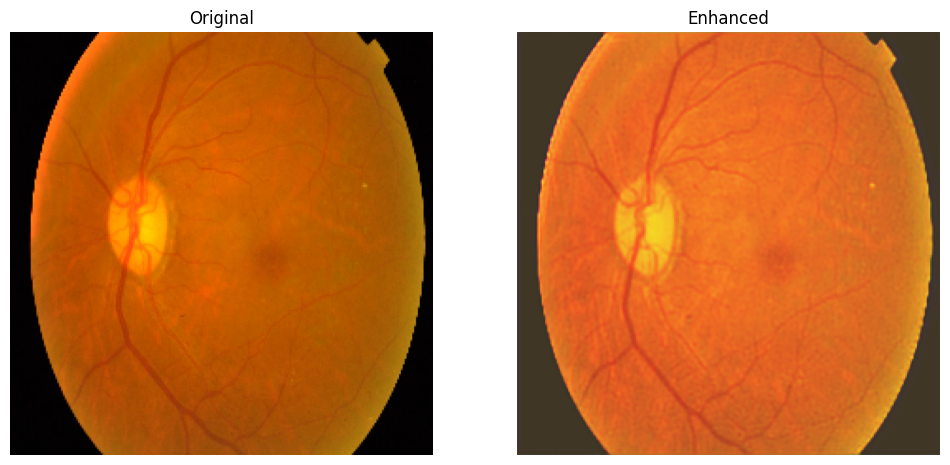

In [44]:
# Display results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(Image.open(test_image_path))
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(enhanced_image)
ax2.set_title('Enhanced')
ax2.axis('off')

plt.show()